In [1]:
import gym
import torch
import sys
import os
import random
import numpy as np
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
sys.path.append('../')
from common import make_env
sys.path.append('../../')
import TD3

import pandas as pd

if not os.path.exists("images"):
    os.mkdir("images")
    
if not os.path.exists("images2"):
    os.mkdir("images2")

In [3]:
response_times = [ 0.01, 0.02, 0.04, 0.08, 0.16, 0.32]

In [4]:
for rt in response_times:
    for neurons in [64, 128, 256, 512, 1024]:
        for seed in range(5):
            if not os.path.isfile('../models/TD3_InvertedPendulum-v2_'+str(seed)+'_0.02_'+str(float(0))+'_'+str(rt)+'_1.0_False_'+str(neurons)+'_final_actor'):
                print (rt, neurons, seed)

0.04 128 0
0.08 128 0
0.16 128 0


In [5]:
df = pd.DataFrame(columns=['seed', 'neurons', 'response_rate', 'reward', 'run_reward', 'control_reward', 'angle', 'jerk'])
# df = torch.load('dataframe_HalfCheetah')
default_timestep = 0.02
default_frame_skip = 2
jit_duration = 0.02
env_name = 'InvertedPendulum-v2'
for response_rate in response_times:
    for neurons in [64, 128, 256, 512, 1024]:
        print(response_rate, neurons)
        for seed in range(5):
            states = []
          
            arguments = ['TD3', env_name, seed, jit_duration, float(0), response_rate, 1.0, False, neurons,'final']
                # Target policy smoothing is scaled wrt the action scale
            file_name = '_'.join([str(x) for x in arguments])
            if response_rate % default_timestep == 0:
                frame_skip = response_rate / default_timestep
                timestep = default_timestep
            elif jit_duration < response_rate:
                timestep = jit_duration
                frame_skip = response_rate / timestep
            else:
                timestep = response_rate
                frame_skip = 1
            jit_frames = 0  # How many frames the horizontal jitter force lasts each time
            if jit_duration:
                if jit_duration % timestep == 0:
                    jit_frames = int(jit_duration / timestep)
                else:
                    raise ValueError(
                        "jit_duration should be a multiple of the timestep: " + str(timestep))
                    
            time_change_factor = (default_timestep * default_frame_skip) / (timestep * frame_skip)
            eval_env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, False)
            eval_env._max_episode_steps = 10000
            state_dim = eval_env.observation_space.shape[0]
            action_dim = eval_env.action_space.shape[0]
            max_action = float(eval_env.action_space.high[0])
            kwargs = {
                "state_dim": state_dim,
                "action_dim": action_dim,
                "observation_space": eval_env.observation_space,
                "max_action": max_action,
                "discount": 0.99,
                "tau": 0.005,
                "neurons": neurons,
            }
            kwargs["policy_noise"] = 2 * max_action
            kwargs["noise_clip"] = 0.5 * max_action
            kwargs["policy_freq"] = 2
            policy = TD3.TD3(**kwargs)
            policy_file = file_name 
            if os.path.exists('../models/'+policy_file+"_critic"):
                policy.load(f"../models/{policy_file}")
                avg_reward = 0.
                avg_run_reward = 0.
                avg_ctrl_reward = 0.
                avg_angle = 0.
                steps = 0

                t = 0
                forces = []
                force_times = []
                for _ in range(1):
                    state, done = eval_env.reset(), False
                    eval_env.model.opt.gravity[0] = 0
                    counter = 0
                    disturb = 5
                    jittering = False
                    force = 0.25
                    prev_action = None
                    jerk = 0
                    while not done:
                        action = policy.select_action(np.array(state))
                        # Perform action
                        if not jittering and round(disturb - counter, 3) >= response_rate:  # Not during the frames when jitter force keeps existing
                            next_state, reward, done, reward_dict = eval_env.step(action)
                            counter += response_rate
                        elif not jittering and round(disturb - counter, 3) < response_rate:
                            forces.append(force)
                            force_times.append(t)
                            jitter_force = force * 9.81 * (2 * (np.random.random() > 0.5) - 1)  # Jitter force strength w/ direction
                            next_state, reward, done, reward_dict = eval_env.jitter_step_start(action, jitter_force,
                                                                                     (disturb - counter) / timestep,
                                                                                     frame_skip - ((disturb - counter) / timestep),
                                                                                     jit_frames)
                            jittered_frames = frame_skip - ((disturb - counter) / timestep)
                            if jittered_frames >= jit_frames:
                                jittered_frames = 0
                                jittering = False
                                eval_env.model.opt.gravity[0] = 0
                                counter = 0
                                force += 0.25

                            else:
                                jittering = True
                                eval_env.model.opt.gravity[0] = jitter_force
                                counter += response_rate
                        elif jit_frames - jittered_frames < frame_skip:  # Jitter force will dispear from now!
                            next_state, reward, done, reward_dict = eval_env.jitter_step_end(
                                action, jitter_force, jit_frames - jittered_frames, frame_skip - (jit_frames - jittered_frames))
                            jittering = False  # Stop jittering now
                            eval_env.model.opt.gravity[0] = 0
                            counter = 0
                            force += 0.25
                        else:  # Jitter force keeps existing now!
                            next_state, reward, done, reward_dict = eval_env.step(action)
                            jittered_frames += frame_skip
                            counter += response_rate
                            if jittered_frames == jit_frames:
                                jittering = False
                                eval_env.model.opt.gravity[0] = 0
                                counter = 0
                                force += 0.25

                        avg_reward += reward
                        avg_angle += abs(next_state[1])
                        state = next_state
                        counter = round(counter, 3)
                        if jit_duration:
                            if counter == disturb:
                                forces.append(force)
                                force_times.append(t)
                                jitter_force = force * 9.81 * (2 * (random.random() > 0.5) - 1)
                                eval_env.model.opt.gravity[0] = jitter_force
                                jittering = True
                                jittered_frames = 0

                        t += 1
                        if prev_action:
                            jerk += abs(action[0] - prev_action)
                        prev_action = action[0]
                        states.append(state)
                states = np.array(states)
                fig = make_subplots(rows=2, cols=1)
                x = [i for i in range(t)]
                for index, f in enumerate(force_times):
                    fig.add_shape(go.layout.Shape(type="line",
                                            x0=f,
                                            y0=-100,
                                            x1=f,
                                            y1=100,
                                            ),row=1,col=1)
                    fig.add_annotation(x=f,
                                       y=0,
                                       text=str(forces[index]), 
                                       showarrow=False,
                                       row=1, col=1)
                fig.add_trace(go.Scatter(x=x, y=states[:,0], mode='lines', name='pos'), row=1, col=1)
                fig.add_trace(go.Scatter(x=x, y=states[:,1], mode='lines', name='angle'), row=2, col=1)
    #             fig.add_trace(go.Scatter(x=x, y=states[:,2], mode='lines', name='vel'))
    #             fig.add_trace(go.Scatter(x=x, y=states[:,3], mode='lines', name='angular vel'))
                fig.update_layout(xaxis_title="Frames")

                fig.write_html("images2/"+file_name+'.html')
        

                avg_reward /= 1
                avg_angle /= 1
                jerk /= avg_reward
                df.loc[len(df.index)] = [seed, neurons, response_rate, avg_reward, avg_run_reward, avg_ctrl_reward, avg_angle, jerk]
                

0.01 64
0.01 128
0.01 256
0.01 512
0.01 1024
0.02 64
0.02 128
0.02 256
0.02 512
0.02 1024
0.04 64
0.04 128
0.04 256
0.04 512
0.04 1024
0.08 64
0.08 128
0.08 256
0.08 512
0.08 1024
0.16 64
0.16 128
0.16 256
0.16 512
0.16 1024
0.32 64
0.32 128
0.32 256
0.32 512
0.32 1024


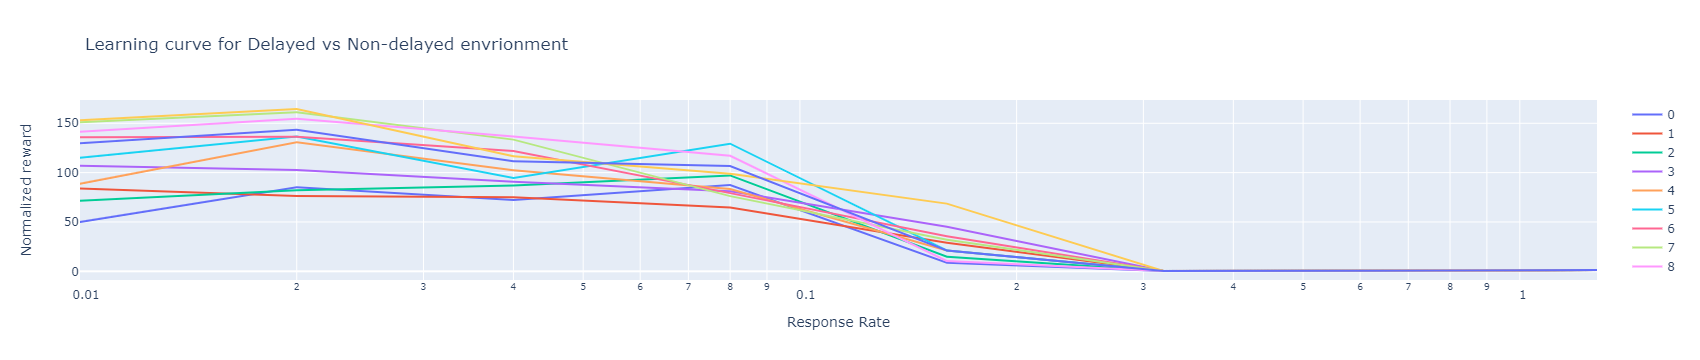

In [18]:
fig = go.Figure()

    
for force in range(11):
    rewards = []
    for rt in response_times:
        temp_df = df.loc[(df['response_rate'] == rt) & (df['g_force'] == force)]
#         print (rt, force, np.mean(temp_df['reward'])* rt)
        rewards.append( np.mean(temp_df['reward'])* rt)
    
    fig.add_trace(go.Scatter(x=response_times, y=rewards, mode='lines', name=str(force)))
    
fig.update_xaxes(type="log")
fig.update_layout(title='Learning curve for Delayed vs Non-delayed envrionment',
                   xaxis_title='Response Rate',
                   yaxis_title='Normalized reward')

fig.show()

In [6]:
df

,seed,neurons,response_rate,reward,run_reward,control_reward,angle,jerk
0,0.0,64.0,0.01,9217.0,0.0,0.0,369.610383,3.996416
1,1.0,64.0,0.01,9762.0,0.0,0.0,375.830833,1.293028
2,2.0,64.0,0.01,7050.0,0.0,0.0,151.240844,1.344749
3,3.0,64.0,0.01,10000.0,0.0,0.0,202.046039,1.170848
4,4.0,64.0,0.01,3021.0,0.0,0.0,21.628896,0.375835
...,...,...,...,...,...,...,...,...
142,0.0,1024.0,0.32,1.0,0.0,0.0,1.684598,0.000000
143,1.0,1024.0,0.32,1.0,0.0,0.0,1.688578,0.000000
144,2.0,1024.0,0.32,1.0,0.0,0.0,1.689693,0.000000
145,3.0,1024.0,0.32,1.0,0.0,0.0,1.686429,0.000000


In [7]:
torch.save(df, 'dataframe_InvertedPendulum_neurons')

In [14]:
df = torch.load('dataframe_InvertedPendulum_neurons')

In [15]:
df['reward'] = df['reward'] * df['response_rate']
rewards = pd.crosstab(df['neurons'], df['response_rate'], values=df['reward'], aggfunc='mean')

In [16]:
rewards

response_rate,0.01,0.02,0.04,0.08,0.16,0.32
neurons,,,,,,
64.0,78.100,44.776,71.408,58.544,25.760,4.160
128.0,81.176,72.076,58.430,70.220,16.320,0.320
256.0,70.416,85.904,76.320,62.864,17.536,0.320
512.0,58.918,76.312,60.360,51.216,18.656,0.832
1024.0,43.534,38.908,74.072,55.856,1.344,0.320


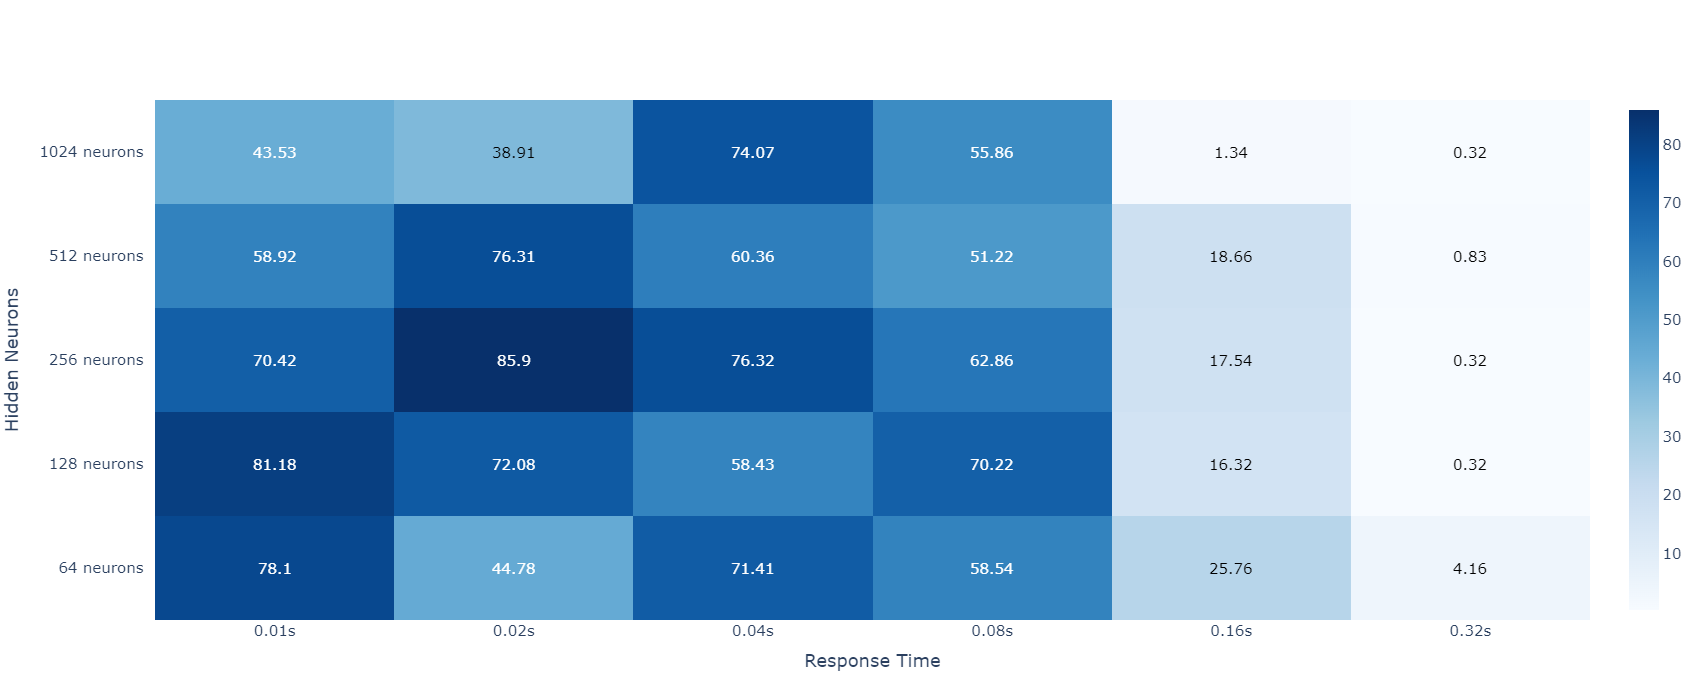

In [19]:
fig = ff.create_annotated_heatmap(z=rewards.to_numpy(),y=[str(int(i))+' neurons' for i in df['neurons'].unique().tolist()], 
                                  x=[str(i) + 's' for i in df['response_rate'].unique().tolist()],  
                                  annotation_text=np.around(rewards.to_numpy(), decimals=2), colorscale='blues', showscale=True,
                                 reversescale =False)

fig.update_layout(
#     title='Average evaluation seconds for response times vs max. pertubation during training',
    xaxis_title="Response Time",
    yaxis_title="Hidden Neurons",
    xaxis_side='bottom',
    font=dict(size=15),
    height=700,
)
fig.show()



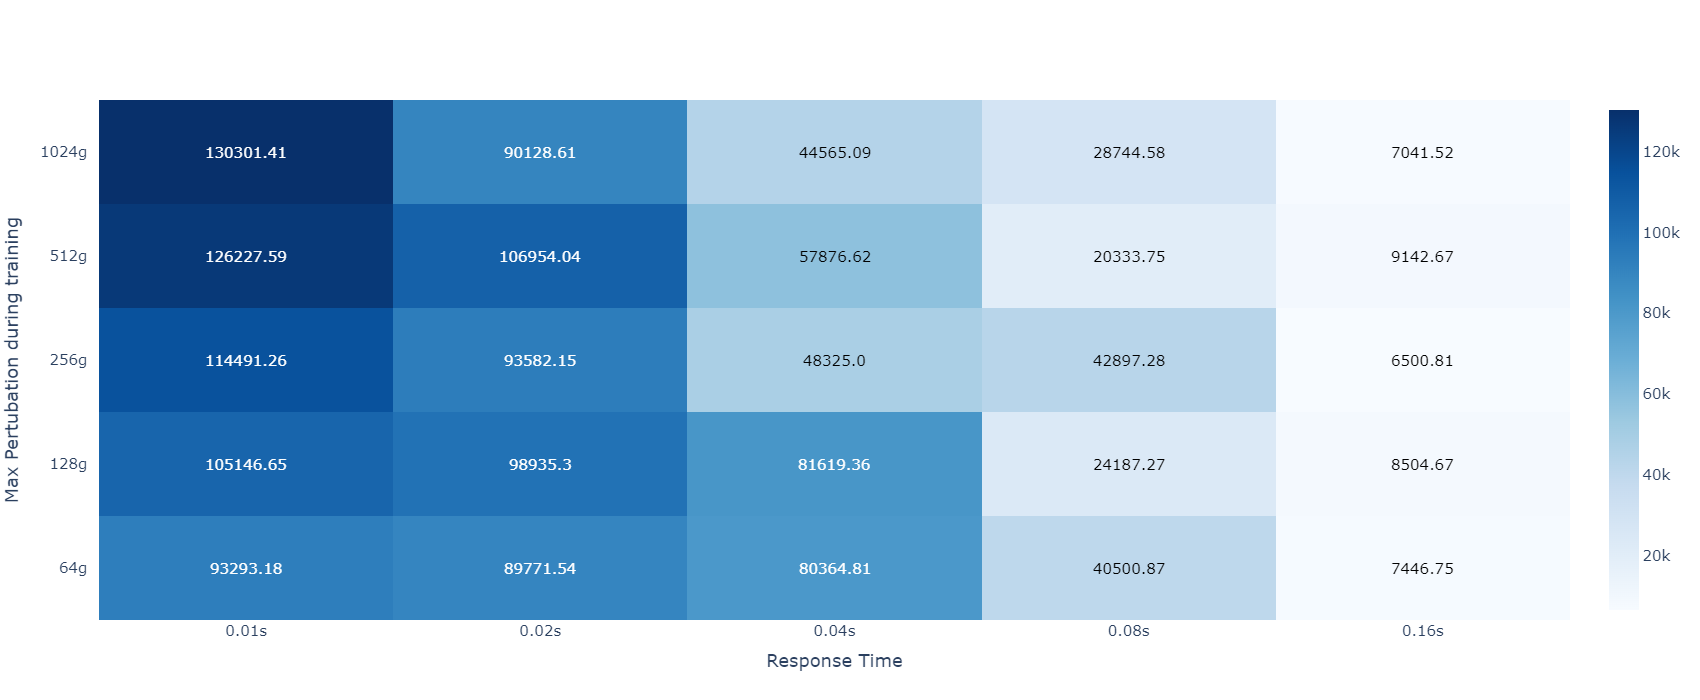

In [17]:
fig = ff.create_annotated_heatmap(z=run_rewards.to_numpy(),y=[str(int(i))+'g' for i in df['neurons'].unique().tolist()], 
                                  x=[str(i) + 's' for i in df['response_rate'].unique().tolist()],  
                                  annotation_text=np.around(run_rewards.to_numpy(), decimals=2), colorscale='blues', showscale=True,
                                 reversescale =False)

fig.update_layout(
#     title='Average evaluation seconds for response times vs max. pertubation during training',
    xaxis_title="Response Time",
    yaxis_title="Max Pertubation during training",
    xaxis_side='bottom',
    font=dict(size=15),
    height=700,
)
fig.show()



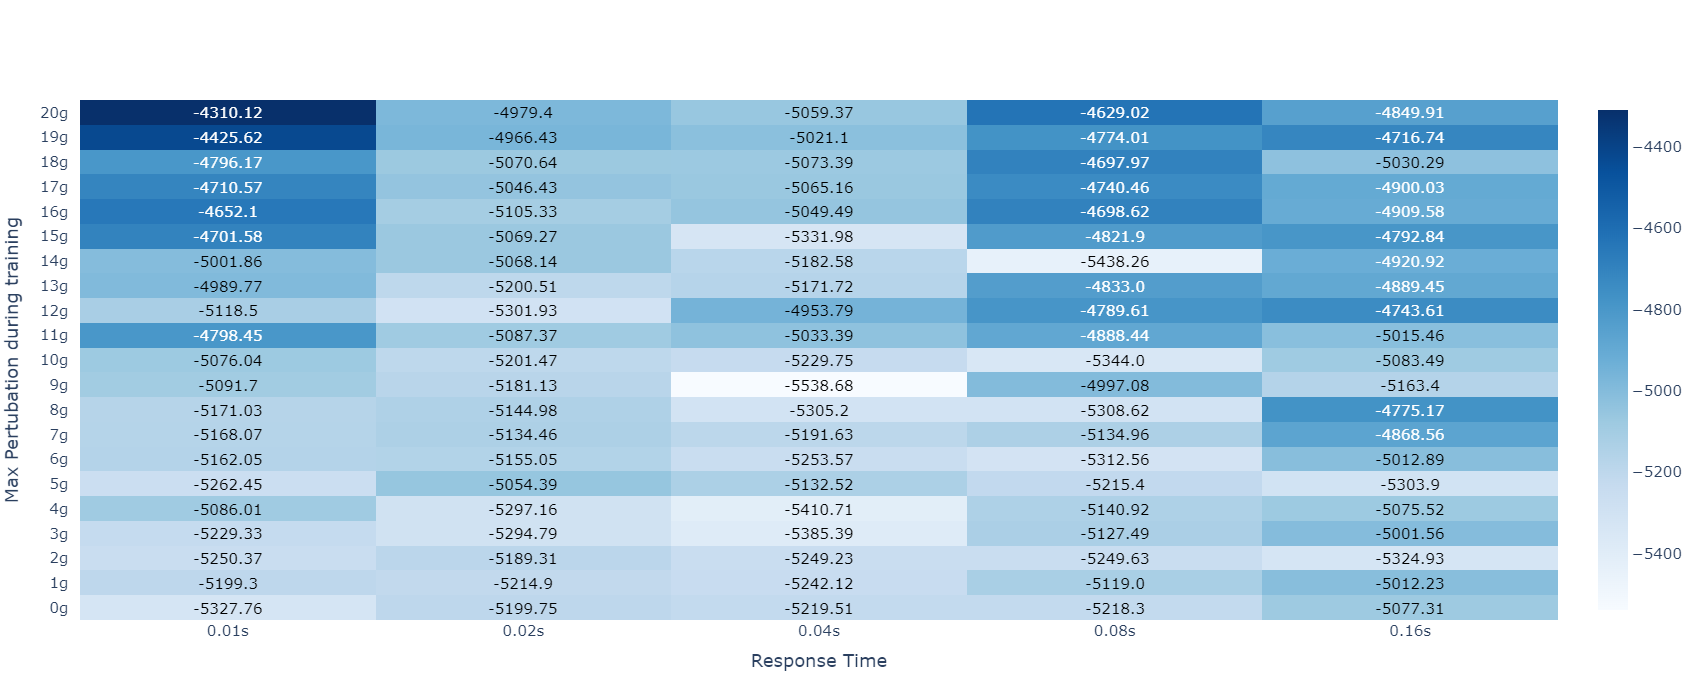

In [22]:
fig = ff.create_annotated_heatmap(z=control_rewards.to_numpy(),y=[str(int(i))+'g' for i in df['g_force'].unique().tolist()], 
                                  x=[str(i) + 's' for i in df['response_rate'].unique().tolist()],  
                                  annotation_text=np.around(control_rewards.to_numpy(), decimals=2), colorscale='blues', showscale=True,
                                 reversescale =False)

fig.update_layout(
#     title='Average evaluation seconds for response times vs max. pertubation during training',
    xaxis_title="Response Time",
    yaxis_title="Max Pertubation during training",
    xaxis_side='bottom',
    font=dict(size=15),
    height=700,
)
fig.show()

